# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import functools
import traceback
import pdb
import pprint
import time

from dotenv import load_dotenv, find_dotenv
import pandas as pd

import langchain
from langchain.llms import OpenAI
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.vectorstores import Chroma

from langchain.embeddings import HuggingFaceInstructEmbeddings

from langchain.schema import Document
from langchain.chains.query_constructor.base import AttributeInfo
from langchain import PromptTemplate

In [3]:
# secret keys
load_dotenv(find_dotenv()) # read local .env file

True

# Setup

In [4]:
recipes_csv = 'data/recipes.csv'
recipes_df = pd.read_csv(recipes_csv)

In [5]:
# Load embedding model
embedding = HuggingFaceInstructEmbeddings(model_name = "hkunlp/instructor-base",
                                          model_kwargs = {'device': 'cpu'}
                                         )

/home/divinekage/miniconda3/envs/RAGcipe/lib/python3.10/site-packages/InstructorEmbedding/instructor.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


load INSTRUCTOR_Transformer


Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


max_seq_length  512


In [6]:
def data_prep(recipes_df):
    titles_documents = df_to_documents(recipes_df,
                                       page_content_column = "title",
                                       metadata_lst = ["title", "cuisine", "Carbs", "Proteins"])
    ingredients_documents = df_to_documents(recipes_df,
                                            page_content_column = "ingredients",
                                            metadata_lst = ["title"])
    return titles_documents, ingredients_documents

def df_to_documents(recipes_df, page_content_column, metadata_lst):
    split_documents = []
    for idx, row in recipes_df.iterrows():
        # create document
        current_document = Document(
            page_content = row[page_content_column],
            metadata = dict(
                (i, row[i])
                for i in metadata_lst
            ),
        )
        # append to document list
        split_documents.append(current_document)
    return split_documents

In [7]:
titles_documents, ingredients_documents = data_prep(recipes_df)

In [8]:
def create_vector_db(titles_documents, ingredients_documents):
    # make vector dbs
    vector_dbs = {}
    vector_dbs["titles_db"] = document_to_vectordb(titles_documents)
    vector_dbs["ingredients_db"] = document_to_vectordb(ingredients_documents)
    return vector_dbs

def document_to_vectordb(split_documents):
    vectordb = Chroma.from_documents(
        documents = split_documents,
        embedding = embedding,
    )
    return vectordb

In [9]:
vector_dbs = create_vector_db(titles_documents, ingredients_documents)

In [10]:
def self_querying_retriever():
    # selection for categories
    allowed_cuisine_lst = ["none", "japanese", "italian", "chinese"]
    allowed_carbohydrates_lst = ["none", "noodles", "rice", "pasta", "bread"]
    allowed_proteins_lst = ["none", "chicken", "seafood", "beef"]

    # Creating our self-querying retriever
    metadata_field_info = [
        AttributeInfo(
            name="title",
            description="Title of the recipe",
            type="string",
        ),
        AttributeInfo(
            name="cuisine",
            description=f"The type of cuisine that the recipe makes. Choose from one of {allowed_cuisine_lst}",
            type="string",
        ),
        AttributeInfo(
            name="Carbs",
            description=f"The kind of carbohydrates used as the base for the recipe. Choose from one of {allowed_carbohydrates_lst}",
            type="string",
        ),
        AttributeInfo(
            name="Proteins",
            description=f"The proteins or meats used for the recipe. Choose from one of {allowed_proteins_lst}",
            type="string",
        ),
    ]
    document_content_description = "Brief descriptions of the recipe"
    return metadata_field_info, document_content_description

In [11]:
metadata_field_info, document_content_description = self_querying_retriever()

# Data

In [12]:
recipes_df

,title,cuisine,Carbs,Proteins,recipe,ingredients
0,Chicken Udon Noodle Soup,japanese,noodles,chicken,1. cook udon noodles according to directions (...,udon noodles\n1 tsp dashi\n1 tsp soy sauce\n1 ...
1,cacio e pepe,italian,pasta,none,"salt\n0.75 cup pecorino romano, plus dusting\n...",salt\npecorino romano\nparmigiano reggiano\np...
2,Creamy Mentaiko Pasta,italian,pasta,none,200g spaghetti \n18g cheese\n1 tbsp cooking oi...,spaghetti\ncheese\ncooking oil\nonion\ngarlic...
3,Beef Enoki Rolls,japanese,none,beef,"Ingredients:\npack shabu beef (half pack, 100g...",shabu beef\nenoki mushrooms\ndashin stock\nsh...
4,Cabbage Rolls in Broth,chinese,none,chicken,Ingredients:\n- 1 cabbage\n- 150g minced chick...,cabbage\nminced chicken\nshrimp paste\nblack ...
5,Chicken Veggie Patties,chinese,none,chicken,Makes 5-6 patties\n\nIngredients:\n- 150g minc...,minced chicken\nfrozen veggies\nonion\ngarlic...
6,Delifrance Inspired Lobster Filling,western,bread,seafood,Serves 2\n\nIngredients:\n- 7 boiled prawns (...,prawns\ncrabmeat\nonion\ntuna\nchili powder\nmayo
7,Mushroom Orzo Risotto (Creamy),italian,pasta,none,Mushroom Orzo Risotto (serves 2)\n\n5 piece mu...,mushrooms\nsalt\npepper\nbutter\ngarlic\nonion...
8,Sour Cream & Chives Pasta,italian,pasta,none,penne for two\n3 tbsp butter\n2 tbsp flour\n20...,penne\nbutter\nflour\nmilk\nsour cream\nchives...
9,Peanut Noodles,chinese,noodles,none,Peanut Noodles (serves 2)\n\nIngredients:\n- n...,noodles\npeanut butter\nsesame oil\nlight soy ...


# SelfQueryRetriever

Set up **SelfQueryRetriever** with descriptions,
specify the constraints for the category prediction
e.g:
- 'cuisine', choose from ['none', 'japanese', 'italian', 'chinese']

In [13]:
metadata_field_info

[AttributeInfo(name='title', description='Title of the recipe', type='string'),
 AttributeInfo(name='cuisine', description="The type of cuisine that the recipe makes. Choose from one of ['none', 'japanese', 'italian', 'chinese']", type='string'),
 AttributeInfo(name='Carbs', description="The kind of carbohydrates used as the base for the recipe. Choose from one of ['none', 'noodles', 'rice', 'pasta', 'bread']", type='string'),
 AttributeInfo(name='Proteins', description="The proteins or meats used for the recipe. Choose from one of ['none', 'chicken', 'seafood', 'beef']", type='string')]

In [14]:
self_querying_retriever = SelfQueryRetriever.from_llm(
    llm = OpenAI(temperature=0),
    vectorstore = vector_dbs['titles_db'],
    document_contents = 'Brief descriptions of the recipe',
    metadata_field_info = metadata_field_info,
    verbose = True
)

## Template prompt provided by **SelfQueryRetriever**

Your goal is to structure the user's query to match the request schema provided below.

<< Structured Request Schema >>
When responding use a markdown code snippet with a JSON object formatted in the following schema:

```json
{
    "query": string \ text string to compare to document contents
    "filter": string \ logical condition statement for filtering documents
}
```

The query string should contain only text that is expected to match the contents of documents. Any conditions in the filter should not be mentioned in the query as well.

A logical condition statement is composed of one or more comparison and logical operation statements.

A comparison statement takes the form: `comp(attr, val)`:
- `comp` (eq | ne | gt | gte | lt | lte): comparator
- `attr` (string):  name of attribute to apply the comparison to
- `val` (string): is the comparison value

A logical operation statement takes the form `op(statement1, statement2, ...)`:
- `op` (and | or): logical operator
- `statement1`, `statement2`, ... (comparison statements or logical operation statements): one or more statements to apply the operation to

Make sure that you only use the comparators and logical operators listed above and no others.
Make sure that filters only refer to attributes that exist in the data source.
Make sure that filters only use the attributed names with its function names if there are functions applied on them.
Make sure that filters only use format `YYYY-MM-DD` when handling timestamp data typed values.
Make sure that filters take into account the descriptions of attributes and only make comparisons that are feasible given the type of data being stored.
Make sure that filters are only used as needed. If there are no filters that should be applied return "NO_FILTER" for the filter value.

<< Example 1. >>
Data Source:
```json
{
    "content": "Lyrics of a song",
    "attributes": {
        "artist": {
            "type": "string",
            "description": "Name of the song artist"
        },
        "length": {
            "type": "integer",
            "description": "Length of the song in seconds"
        },
        "genre": {
            "type": "string",
            "description": "The song genre, one of "pop", "rock" or "rap""
        }
    }
}
```

User Query:
What are songs by Taylor Swift or Katy Perry about teenage romance under 3 minutes long in the dance pop genre

Structured Request:
```json
{
    "query": "teenager love",
    "filter": "and(or(eq(\"artist\", \"Taylor Swift\"), eq(\"artist\", \"Katy Perry\")), lt(\"length\", 180), eq(\"genre\", \"pop\"))"
}
```


<< Example 2. >>
Data Source:
```json
{
    "content": "Lyrics of a song",
    "attributes": {
        "artist": {
            "type": "string",
            "description": "Name of the song artist"
        },
        "length": {
            "type": "integer",
            "description": "Length of the song in seconds"
        },
        "genre": {
            "type": "string",
            "description": "The song genre, one of "pop", "rock" or "rap""
        }
    }
}
```

User Query:
What are songs that were not published on Spotify

Structured Request:
```json
{
    "query": "",
    "filter": "NO_FILTER"
}
```


<< Example 3. >>
Data Source:
```json
{
    "content": "Brief descriptions of the recipe",
    "attributes": {
        "title": {
            "description": "Title of the recipe",
            "type": "string"
        },
        "cuisine": {
            "description": "The type of cuisine that the recipe makes. Choose from one of ['none', 'japanese', 'italian', 'chinese']",
            "type": "string"
        },
        "Carbs": {
            "description": "The kind of carbohydrates used as the base for the recipe. Choose from one of ['none', 'noodles', 'rice', 'pasta', 'bread']",
            "type": "string"
        },
        "Proteins": {
            "description": "The proteins or meats used for the recipe. Choose from one of ['none', 'chicken', 'seafood', 'beef']",
            "type": "string"
        }
    }
}
```

User Query: i want to eat something italian, with seafood

Structured Request:

# Run inference

```json
{
    "content": "Brief descriptions of the recipe",
    "attributes": {
    "title": {
        "description": "Title of the recipe",
        "type": "string"
    },
    "cuisine": {
        "description": "The type of cuisine that the recipe makes. Choose from one of ['none', 'japanese', 'italian', 'chinese']",
        "type": "string"
    },
    "Carbs": {
        "description": "The kind of carbohydrates used as the base for the recipe. Choose from one of ['none', 'noodles', 'rice', 'pasta', 'bread']",
        "type": "string"
    },
    "Proteins": {
        "description": "The proteins or meats used for the recipe. Choose from one of ['none', 'chicken', 'seafood', 'beef']",
        "type": "string"
    }
}
```

```json
{
    "query": "<something about the food>",
    "filter": "and(eq(\"cuisine\", \"italian\"), eq(\"Proteins\", \"seafood\"))"
}
```

## italian + seafood

In [ ]:
user_input = f"""
i want to eat something italian, with seafood
"""

In [15]:
recipes_df[recipes_df.apply(lambda x: 
                            (x['cuisine'] == 'italian') and \
                            (x['Proteins'] == 'seafood')
                            , axis=1)]

,title,cuisine,Carbs,Proteins,recipe,ingredients
10,Vongole Pasta,italian,pasta,seafood,Vongole Pasta (serves 2)\n\n500g-700g clams\n2...,clams\ngarlic\nbutter\nwhite wine\ndried chill...
11,Prawn Pesto Spaghetti,italian,pasta,seafood,1. Take 12-14 prawns. Thaw and dry them\n2. Ma...,12-14 prawns\npepper\nherbs\nchilli powder\n1 ...
12,Prawn Pesto Penne,italian,pasta,seafood,1. Take 12-14 prawns. Thaw and dry them\n2. Ma...,12-14 prawns\npepper\nherbs\nchilli powder\n1 ...


In [40]:
output_lst = self_querying_retriever.get_relevant_documents(user_input)
print('----------')
for document in output_lst:
    print(document)

query=' ' filter=Operation(operator=<Operator.AND: 'and'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='cuisine', value='italian'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='Proteins', value='seafood')]) limit=None
----------
page_content='Vongole Pasta' metadata={'Carbs': 'pasta', 'Proteins': 'seafood', 'cuisine': 'italian', 'title': 'Vongole Pasta'}
page_content='Prawn Pesto Penne' metadata={'Carbs': 'pasta', 'Proteins': 'seafood', 'cuisine': 'italian', 'title': 'Prawn Pesto Penne'}
page_content='Prawn Pesto Spaghetti' metadata={'Carbs': 'pasta', 'Proteins': 'seafood', 'cuisine': 'italian', 'title': 'Prawn Pesto Spaghetti'}


## japanese + {chicken, beef}

In [ ]:
user_input = f"""
i want a japanese cuisine, with chicken or beef meats
"""

In [17]:
recipes_df[recipes_df.apply(lambda x: 
                            (x['cuisine'] == 'japanese') and \
                            (x['Proteins'] in ['chicken', 'beef'])
                            , axis=1)]

,title,cuisine,Carbs,Proteins,recipe,ingredients
0,Chicken Udon Noodle Soup,japanese,noodles,chicken,1. cook udon noodles according to directions (...,udon noodles\n1 tsp dashi\n1 tsp soy sauce\n1 ...
3,Beef Enoki Rolls,japanese,none,beef,"Ingredients:\npack shabu beef (half pack, 100g...",shabu beef\nenoki mushrooms\ndashin stock\nsh...


In [18]:
output_lst = self_querying_retriever.get_relevant_documents(user_input)
print('----------')
for document in output_lst:
    print(document)

/home/divinekage/miniconda3/envs/RAGcipe/lib/python3.10/site-packages/langchain/chains/llm.py:280: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


query=' ' filter=Operation(operator=<Operator.AND: 'and'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='cuisine', value='japanese'), Operation(operator=<Operator.OR: 'or'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='Proteins', value='chicken'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='Proteins', value='beef')])]) limit=None
----------
page_content='Beef Enoki Rolls' metadata={'Carbs': 'none', 'Proteins': 'beef', 'cuisine': 'japanese', 'title': 'Beef Enoki Rolls'}
page_content='Chicken Udon Noodle Soup' metadata={'Carbs': 'noodles', 'Proteins': 'chicken', 'cuisine': 'japanese', 'title': 'Chicken Udon Noodle Soup'}


# Visualization

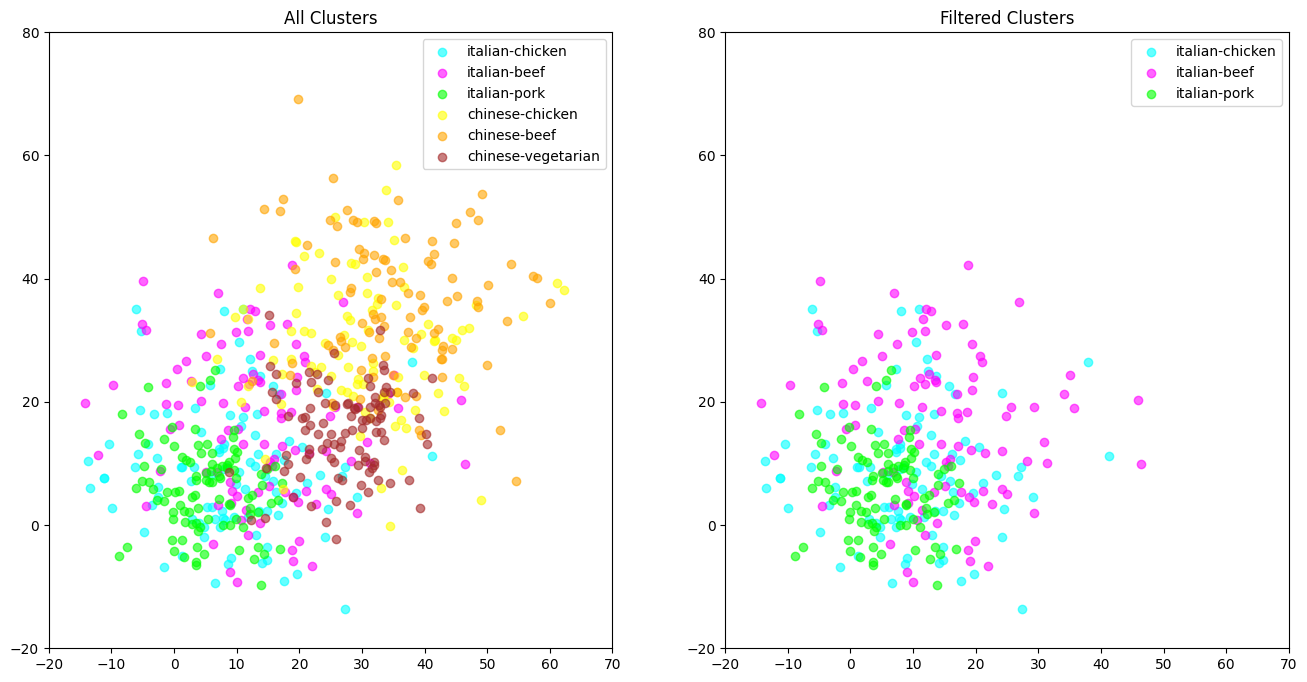

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data for cluster 0 and cluster 1
n_points = 100
cluster_0 = np.random.normal(loc=[0, 0], scale=[5, 5], size=(n_points, 2))
cluster_1 = np.random.normal(loc=[20, 20], scale=[5, 5], size=(n_points, 2))
# Generate synthetic data for cluster 2 and cluster 3
cluster_2 = np.random.normal(loc=[10, 10], scale=[10, 10], size=(n_points, 2))
cluster_3 = np.random.normal(loc=[15, 15], scale=[10, 10], size=(n_points, 2))


# Create merged clusters as specified
cluster_0_2 = cluster_0 + cluster_2
cluster_0_3 = cluster_0 + cluster_3
cluster_1_2 = cluster_1 + cluster_2
cluster_1_3 = cluster_1 + cluster_3
# Generate synthetic data for new clusters: italian-pork and chinese-vegetarian
cluster_italian_pork = cluster_0 + np.random.normal(loc=[5, 5], scale=[5, 5], size=(n_points, 2))
cluster_chinese_vegetarian = cluster_1 + np.random.normal(loc=[5, -5], scale=[5, 5], size=(n_points, 2))

# Plot clusters with the new additions
plt.figure(figsize=(16, 8))

# Merged Clusters
plt.subplot(1,2,1)
plt.scatter(cluster_0_2[:, 0], cluster_0_2[:, 1], c='cyan', label='italian-chicken', alpha=0.6)
plt.scatter(cluster_0_3[:, 0], cluster_0_3[:, 1], c='magenta', label='italian-beef', alpha=0.6)
plt.scatter(cluster_italian_pork[:, 0], cluster_italian_pork[:, 1], c='lime', label='italian-pork', alpha=0.6)
plt.scatter(cluster_1_2[:, 0], cluster_1_2[:, 1], c='yellow', label='chinese-chicken', alpha=0.6)
plt.scatter(cluster_1_3[:, 0], cluster_1_3[:, 1], c='orange', label='chinese-beef', alpha=0.6)
plt.scatter(cluster_chinese_vegetarian[:, 0], cluster_chinese_vegetarian[:, 1], c='brown', label='chinese-vegetarian', alpha=0.6)
# 
plt.xlim([-20, 70])
plt.ylim([-20, 80])
plt.legend()
plt.title('All Clusters')


# Merged Clusters
plt.subplot(1,2,2)
plt.scatter(cluster_0_2[:, 0], cluster_0_2[:, 1], c='cyan', label='italian-chicken', alpha=0.6)
plt.scatter(cluster_0_3[:, 0], cluster_0_3[:, 1], c='magenta', label='italian-beef', alpha=0.6)
plt.scatter(cluster_italian_pork[:, 0], cluster_italian_pork[:, 1], c='lime', label='italian-pork', alpha=0.6)
# 
plt.xlim([-20, 70])
plt.ylim([-20, 80])
plt.legend()
plt.title('Filtered Clusters')


plt.show()
